In [ ]:
import torch
TORCH = torch.__version__.split("+")[0]
CUDA = "cu" + torch.version.cuda.replace(".","")
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import torch_geometric
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.datasets import Amazon
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
import torch_geometric.nn as gnn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
#set seed
random.seed(42)
torch.manual_seed(42)

In [ ]:
# Amazon Computers dataset
dataset = Amazon(root='dataset/Amazon', name='Computers')

# Access dataset information
print('Dataset: ', dataset)
print('Number of graphs: ', len(dataset))
print('Number of classes: ', dataset.num_classes)
print('Number of features: ', dataset.num_features)

# Access the only graph in the dataset
data = dataset[0]
print('Graph information: ', data)
print('Number of nodes: ', data.num_nodes)
print('Number of edges: ', data.num_edges)
print('Node features shape: ', data.x.shape)
print('Node labels shape: ', data.y.shape)
print('Edge index shape: ', data.edge_index.shape)

Dataset:  AmazonComputers()
Number of graphs:  1
Number of classes:  10
Number of features:  767
Graph information:  Data(x=[13752, 767], edge_index=[2, 491722], y=[13752])
Number of nodes:  13752
Number of edges:  491722
Node features shape:  torch.Size([13752, 767])
Node labels shape:  torch.Size([13752])
Edge index shape:  torch.Size([2, 491722])


<ipython-input-270-04a9ff24fd3a>:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


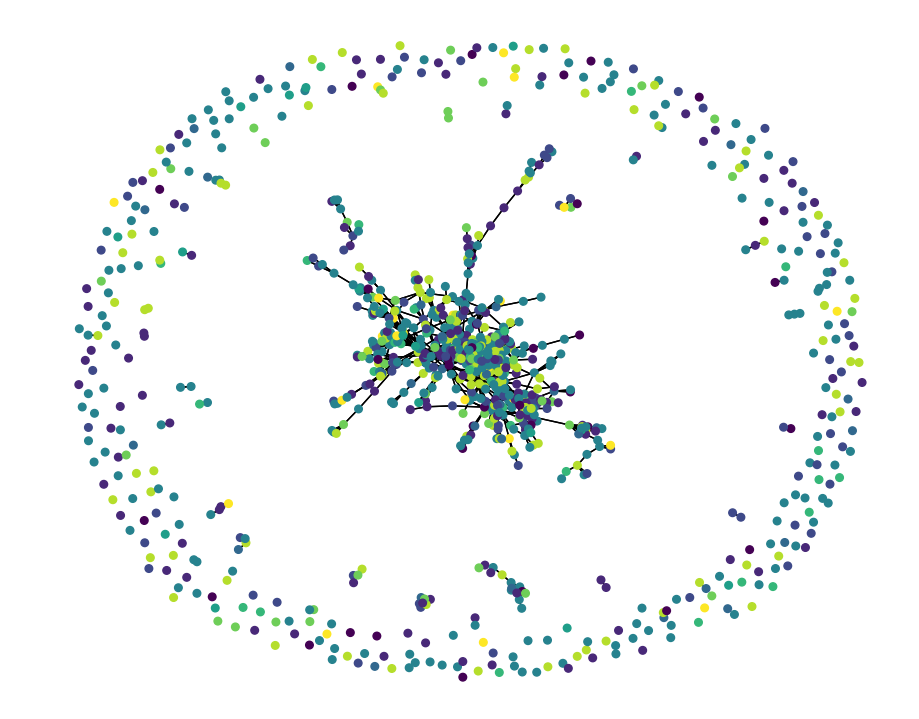

In [ ]:
#visualize (a part) of the graph
def convert_to_networkx(graph, n_sample=None):
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()
    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]
    return g, y


def plot_graph(g, y):
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show()

g, y = convert_to_networkx(data, n_sample=1000)
plot_graph(g, y)

In [ ]:
#slit data in training, validation and test set
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(data)

In [ ]:
# Define the GNN model
class GNNModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = gnn.GCNConv(num_features, 128)
        #self.conv2 = gnn.GCNConv(64, 64)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        #x = torch.relu(x)
        #x = self.conv2(x, edge_index)
        x = torch.relu(x)
        #x = gnn.global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long, device=x.device))  # Global Mean Pooling
        x = self.fc(x)
        return x

In [ ]:
#define train and evaluation functions
def validate(model, epochs, optimizer, criterion, data):
  model.eval()
  with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))
    valid_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    pred = out.argmax(dim=1)
    valid_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    return valid_acc

def train(model, epochs, optimizer, criterion, data):
  train_accuracy = []
  valid_accuracy = []
  for i in range(0, epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pred = out.argmax(dim=1)
    train_acc = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    train_accuracy.append(train_acc)
    if i % 10 == 0:
      valid_acc = validate(model, epochs, optimizer, criterion, data)
      valid_accuracy.append(valid_acc)
      print("Epoch ", i ," | Accuracy on validation: ", valid_acc)

  return model, train_accuracy, valid_accuracy


def evaluate(model, data):
    model.eval()
    with torch.no_grad():
      logits = model(data.x.to(device), data.edge_index.to(device))
      pred = logits.argmax(dim=1)
      acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
      #accuracy = accuracy_score(true_labels, predicted_labels)
      precision = precision_score(data.y[data.test_mask], pred[data.test_mask], average='macro')
      recall = recall_score(data.y[data.test_mask], pred[data.test_mask], average='macro')
      f1 = f1_score(data.y[data.test_mask], pred[data.test_mask], average='macro')

      print("Accuracy: ", acc)
      print("Precision: ", precision)
      print("Recall: ", recall)
      print("F1-score: ", f1)

In [ ]:
#Create and train the model
model = GNNModel(dataset.num_node_features, dataset.num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

model, train_acc, valid_acc = train(model, 150, optimizer, criterion, graph)

Epoch  0  | Accuracy on validation:  0.3927272727272727
Epoch  10  | Accuracy on validation:  0.5585454545454546
Epoch  20  | Accuracy on validation:  0.6247272727272727
Epoch  30  | Accuracy on validation:  0.7687272727272727
Epoch  40  | Accuracy on validation:  0.8261818181818181
Epoch  50  | Accuracy on validation:  0.8581818181818182
Epoch  60  | Accuracy on validation:  0.8690909090909091
Epoch  70  | Accuracy on validation:  0.8778181818181818
Epoch  80  | Accuracy on validation:  0.885090909090909
Epoch  90  | Accuracy on validation:  0.8872727272727273
Epoch  100  | Accuracy on validation:  0.8952727272727272
Epoch  110  | Accuracy on validation:  0.9003636363636364
Epoch  120  | Accuracy on validation:  0.9018181818181819
Epoch  130  | Accuracy on validation:  0.904
Epoch  140  | Accuracy on validation:  0.9069090909090909


In [ ]:
#evaluate the model (on test set)
evaluate(model, graph)

Accuracy:  0.9058181818181819
Precision:  0.9010670410414502
Recall:  0.8870893690723121
F1-score:  0.8917821368580878


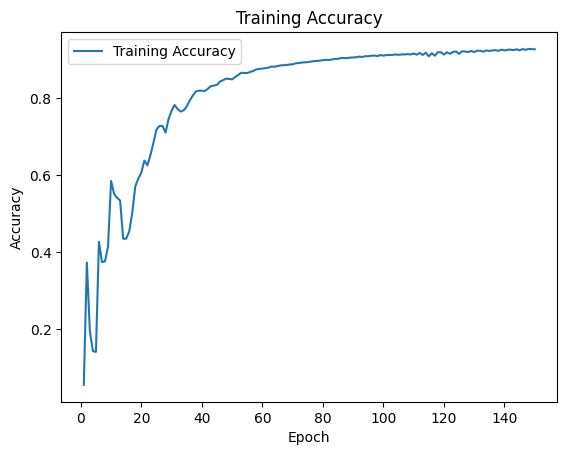

In [ ]:
#plot train accuracy
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

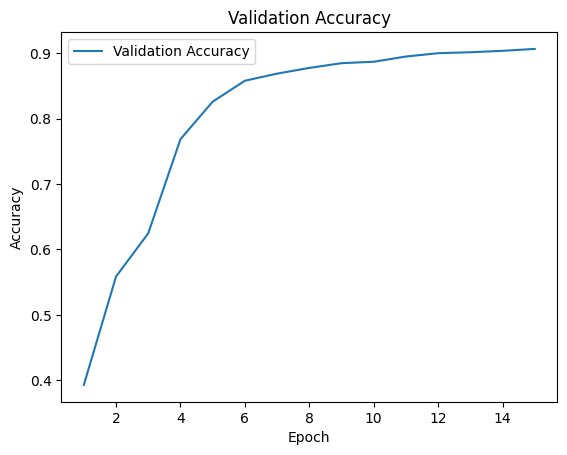

In [ ]:
# Plot valid accuracy
plt.plot(range(1, len(valid_acc) + 1), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

Adding Pooling option before the elaboration

In [ ]:
# Pooling to remove the nodes with the smallest degree
def graph_pooling(data):
    degrees = data.edge_index[0].bincount()
    min_degree_nodes = degrees.argmin(dim=0)

    selected_nodes = degrees > degrees[min_degree_nodes]
    data.x = data.x[selected_nodes]
    data.y = data.y[selected_nodes].squeeze()
    data.train_mask = data.train_mask[selected_nodes]
    data.val_mask = data.val_mask[selected_nodes]
    data.test_mask = data.test_mask[selected_nodes]
    data.edge_index, mapping = torch_geometric.utils.subgraph(
        selected_nodes, data.edge_index, relabel_nodes=True
    )
    data.y = data.y[mapping].squeeze()
    print(data)

    return data


In [ ]:
# Pooling to select the top k nodes
def graph_pooling_topk(data, k, degrees):
  # Sort nodes based on degrees and select the top-k nodes
  _, topk_indices = torch.topk(degrees, k, largest=True)

  # Keep only the top-k nodes and their corresponding edges
  data.x = data.x[topk_indices]
  data.y = data.y[topk_indices]
  data.train_mask = data.train_mask[topk_indices]
  data.val_mask = data.val_mask[topk_indices]
  data.test_mask = data.test_mask[topk_indices]
  data.edge_index, mapping = torch_geometric.utils.subgraph(
    topk_indices, data.edge_index, relabel_nodes=True
  )
  data.y = data.y[mapping].squeeze()

  return data

In [ ]:
#def to choose the type of pooling
def choose_pooling(pool_type, data, g=None, k=100):
  if pool_type == "min_deg":
    return graph_pooling(data)
  elif pool_type == "top_k":
    degrees = [val for (node, val) in g.degree()]
    degrees = torch.FloatTensor(degrees)
    return graph_pooling_topk(data, k, degrees)
  else:
    return []

In [ ]:
pooled_data = choose_pooling("top_k", graph, g=g, k=1000)

In [ ]:
#Create and train the model
model = GNNModel(dataset.num_node_features, dataset.num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

model, train_acc, valid_acc = train(model, 150, optimizer, criterion, pooled_data)

Epoch  0  | Accuracy on validation:  0.3409090909090909
Epoch  10  | Accuracy on validation:  0.5795454545454546
Epoch  20  | Accuracy on validation:  0.6590909090909091
Epoch  30  | Accuracy on validation:  0.7727272727272727
Epoch  40  | Accuracy on validation:  0.8068181818181818
Epoch  50  | Accuracy on validation:  0.7954545454545454
Epoch  60  | Accuracy on validation:  0.7840909090909091
Epoch  70  | Accuracy on validation:  0.7840909090909091
Epoch  80  | Accuracy on validation:  0.7727272727272727
Epoch  90  | Accuracy on validation:  0.7613636363636364
Epoch  100  | Accuracy on validation:  0.7840909090909091
Epoch  110  | Accuracy on validation:  0.7613636363636364
Epoch  120  | Accuracy on validation:  0.7613636363636364
Epoch  130  | Accuracy on validation:  0.7727272727272727
Epoch  140  | Accuracy on validation:  0.7613636363636364
